In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from skimage.measure import label

import cv2
from skimage import filters, color, io, feature
from scipy.ndimage import median_filter
from skimage.morphology import closing, square
from sklearn.cluster import DBSCAN
from skimage.filters import threshold_otsu
from skimage.filters import unsharp_mask
from sklearn.mixture import GaussianMixture

import os
os.chdir("../")
from Sources.tools import *

# Load preprocess data

In [2]:
breast_images_without_label = np.load('Data/images_without_label_1_step_morpho.npy', allow_pickle=True)

# Get Region of Interest

In [231]:
image = breast_images_without_label[2]
normalized_image = image / 255.0

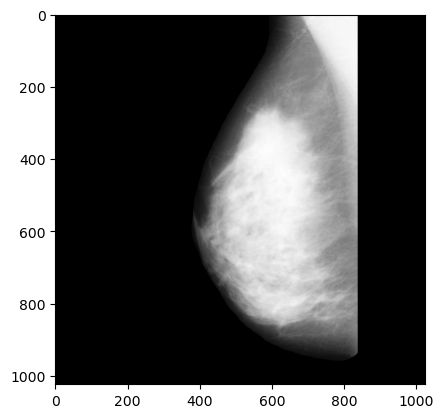

In [232]:
plt.imshow(image, cmap="grey")

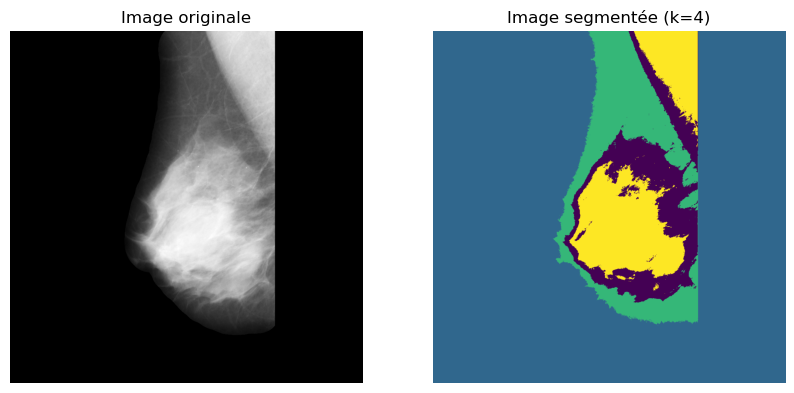

In [93]:
n_clusters = 4

pixels = image.reshape(-1, 1)

# Apply K-Means clustering
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(pixels)

# Récupérer les étiquettes des clusters
labels = kmeans.labels_

# Remapper les labels dans une image 2D
segmented_image = labels.reshape(image.shape)

# Visualiser l'image segmentée
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Image originale")
plt.imshow(image, cmap="gray")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title(f"Image segmentée (k={n_clusters})")
plt.imshow(segmented_image, cmap="viridis")  # Utilise une colormap colorée pour visualiser les clusters
plt.axis("off")

plt.show()

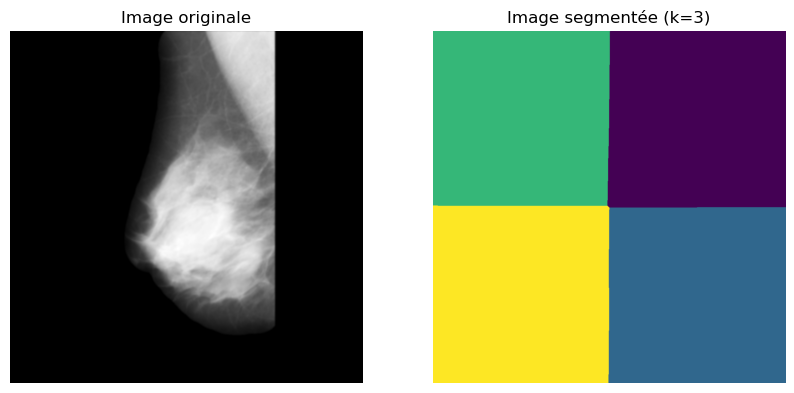

In [96]:
image = breast_images_without_label[0]
normalized_image = image / 255.0


# Lissage pour réduire le bruit
smoothed_image = gaussian_filter(normalized_image, sigma=2)

n_clusters = 3

# Dimensions de l'image
h, w = smoothed_image.shape

# Création des coordonnées spatiales (x, y)
x, y = np.meshgrid(np.arange(w), np.arange(h))
coords = np.stack([x.ravel(), y.ravel()], axis=1)  # Coordonnées des pixels

# Normalisation des coordonnées
coords = coords / np.array([w, h])  # Normaliser entre 0 et 1

# Ajout des valeurs de pixels
pixel_values = smoothed_image.ravel().reshape(-1, 1)

# Concaténer les coordonnées normalisées avec les valeurs de pixels
spatial_weight = 10  # Donne moins d'importance aux coordonnées
features = np.hstack([coords * spatial_weight, pixel_values])

# Appliquer K-Means sur les nouvelles caractéristiques
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(features)

# Reshape des labels pour avoir l'image segmentée
segmented_image = kmeans.labels_.reshape(h, w)


# Visualiser l'image segmentée
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Image originale")
plt.imshow(smoothed_image, cmap="gray")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title(f"Image segmentée (k={n_clusters})")
plt.imshow(segmented_image, cmap="viridis")  # Utilise une colormap colorée pour visualiser les clusters
plt.axis("off")

plt.show()

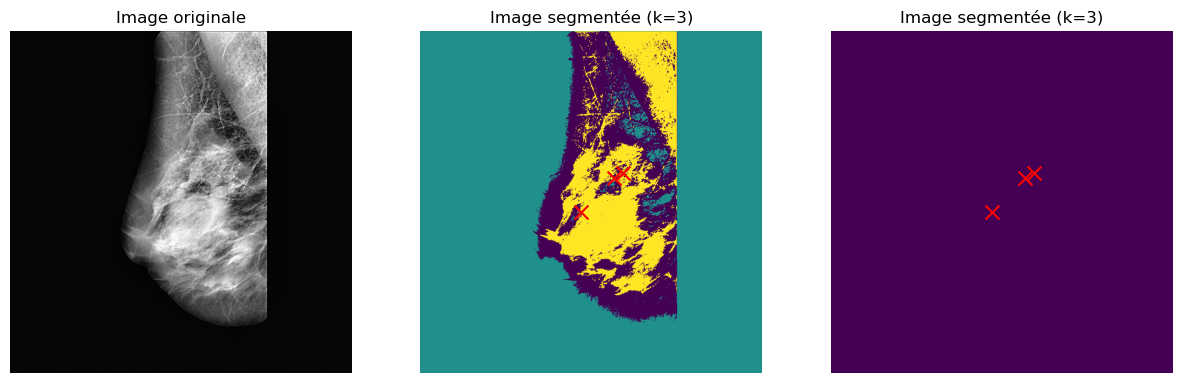

In [ ]:
image = breast_images_without_label[0]
#normalized_image = image / 255.0

# Appliquer un filtre médian
filtered_image = median_filter(image, size=2)  # Taille de la fenêtre = 3x3

# Create a CLAHE object (clipLimit=2.0 and tileGridSize=(8,8) are common default values)
clahe = cv2.createCLAHE(clipLimit=5.0, tileGridSize=(10, 10))

# Apply CLAHE to the grayscale image
clahe_image = clahe.apply(filtered_image)

# Apply unsharp masking
sharpened_image = unsharp_mask(clahe_image, radius=2, amount=1.5)

normalized_image = sharpened_image / 255.0


n_clusters = 3

# Dimensions de l'image
h, w = normalized_image.shape

# Création des coordonnées spatiales (x, y)
x, y = np.meshgrid(np.arange(w), np.arange(h))
coords = np.stack([x.ravel(), y.ravel()], axis=1)  # Coordonnées des pixels

# Normalisation des coordonnées
coords = coords / np.array([w, h])  # Normaliser entre 0 et 1

# Ajout des valeurs de pixels
pixel_values = normalized_image.ravel().reshape(-1, 1)

# Concaténer les coordonnées normalisées avec les valeurs de pixels
spatial_weight = 0.000001  # Donne moins d'importance aux coordonnées
features = np.hstack([coords * spatial_weight, pixel_values])

# Appliquer K-Means sur les nouvelles caractéristiques
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(features)

# Récupérer les centres des clusters (en coordonnées normalisées)
centroids_normalized = kmeans.cluster_centers_[:, :2]  # On prend seulement les coordonnées (x, y)
centroids = centroids_normalized * np.array([w, h]) / spatial_weight  # Revenir aux coordonnées de l'image

# Reshape des labels pour avoir l'image segmentée
segmented_image = kmeans.labels_.reshape(h, w)



# Trouver les centres des clusters
centers = np.copy(centroids)

# Définir un seuil de distance pour considérer un cluster comme englobé
distance_threshold = 0.01

# Fonction pour vérifier l'enveloppement
def is_enclosed(cluster1_points, cluster2_points, distance_threshold):
    # Vérifier si tous les points de cluster1 sont à une distance inférieure à distance_threshold de cluster2
    distances = np.linalg.norm(cluster1_points - cluster2_points.mean(axis=0), axis=1)
    return np.all(distances < distance_threshold)

modified_labels = np.copy(kmeans.labels_)
# Vérification des relations d'enveloppement
for i in range(len(centers)):
    for j in range(i+1, len(centers)):
        # Extraire les points des clusters i et j
        cluster_i_points = features[modified_labels == i]
        cluster_j_points = features[modified_labels == j]
        
        # Vérifier si le cluster i est englobé dans le cluster j
        if is_enclosed(cluster_i_points, cluster_j_points, distance_threshold):
            # Réassigner les labels du cluster i au cluster j
            modified_labels[modified_labels == i] = j

segmented_image_modified = modified_labels.reshape(h, w)

# Visualiser l'image segmentée
plt.figure(figsize=(15, 10))
plt.subplot(1, 3, 1)
plt.title("Image originale")
plt.imshow(normalized_image, cmap="gray")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title(f"Image segmentée (k={n_clusters})")
plt.imshow(segmented_image, cmap="viridis")  # Utilise une colormap colorée pour visualiser les clusters
plt.scatter(centroids[:, 0], centroids[:, 1], color='red', marker='x', s=100, label="Centres des Clusters")
plt.axis("off")


plt.subplot(1, 3, 3)
plt.title(f"Image segmentée (k={n_clusters})")
plt.imshow(segmented_image_modified, cmap="viridis")  # Utilise une colormap colorée pour visualiser les clusters
plt.scatter(centroids[:, 0], centroids[:, 1], color='red', marker='x', s=100, label="Centres des Clusters")
plt.axis("off")
plt.show()

In [107]:
print(np.unique(modified_labels))  # Vérifie les valeurs uniques des labels

[2]


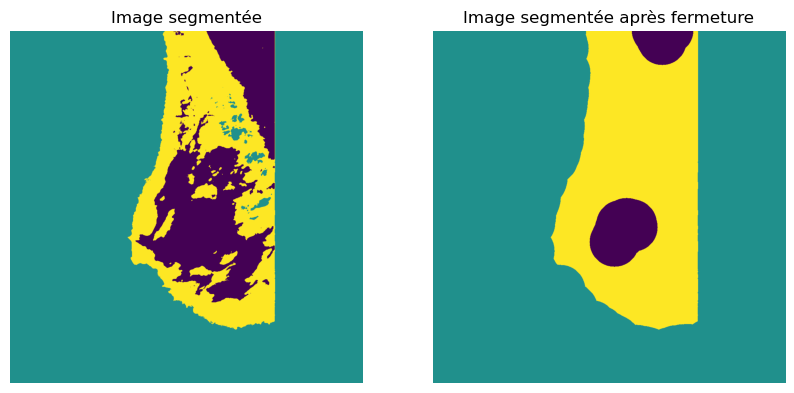

In [45]:
closed_image = closing(segmented_image, morphology.disk(70))

# Visualiser l'image segmentée après la fermeture
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Image segmentée")
plt.imshow(segmented_image, cmap="viridis")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Image segmentée après fermeture")
plt.imshow(closed_image, cmap="viridis")
plt.axis("off")

plt.show()

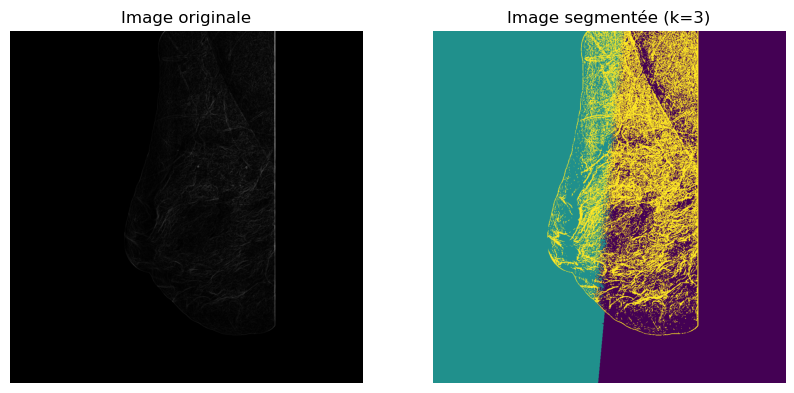

In [213]:
image = breast_images_without_label[0]
normalized_image = image / 255.0

# Create a CLAHE object (clipLimit=2.0 and tileGridSize=(8,8) are common default values)
clahe = cv2.createCLAHE(clipLimit=4.0, tileGridSize=(10, 10))

# Apply CLAHE to the grayscale image
clahe_image = clahe.apply(image)

# Calcul du gradient en x avec le filtre Sobel
gradient_x = cv2.Sobel(clahe_image, cv2.CV_64F, 1, 0, ksize=3)

# Calcul du gradient en y avec le filtre Sobel
gradient_y = cv2.Sobel(clahe_image, cv2.CV_64F, 0, 1, ksize=3)

# Calcul de l'amplitude du gradient (magnitude)
gradient_magnitude = cv2.magnitude(gradient_x, gradient_y)

n_clusters = 3

# Dimensions de l'image
h, w = gradient_magnitude.shape

# Création des coordonnées spatiales (x, y)
x, y = np.meshgrid(np.arange(w), np.arange(h))
coords = np.stack([x.ravel(), y.ravel()], axis=1)  # Coordonnées des pixels

# Normalisation des coordonnées
coords = coords / np.array([w, h])  # Normaliser entre 0 et 1

# Ajout des valeurs de pixels
pixel_values = gradient_magnitude.ravel().reshape(-1, 1)

# Concaténer les coordonnées normalisées avec les valeurs de pixels
spatial_weight = 70  # Donne moins d'importance aux coordonnées
features = np.hstack([coords * spatial_weight, pixel_values])

# Appliquer K-Means sur les nouvelles caractéristiques
kmeans = KMeans(n_clusters=n_clusters, random_state=42, init="random")
kmeans.fit(features)

# Reshape des labels pour avoir l'image segmentée
segmented_image = kmeans.labels_.reshape(h, w)


# Visualiser l'image segmentée
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Image originale")
plt.imshow(gradient_magnitude, cmap="gray")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title(f"Image segmentée (k={n_clusters})")
plt.imshow(segmented_image, cmap="viridis")  # Utilise une colormap colorée pour visualiser les clusters
plt.axis("off")

plt.show()

In [301]:
image = breast_images_without_label[0]

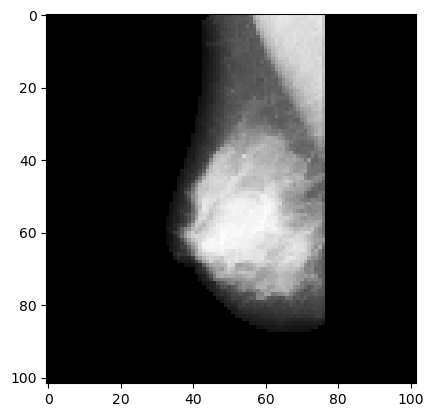

In [306]:
plt.imshow(reduced_image, cmap="grey")

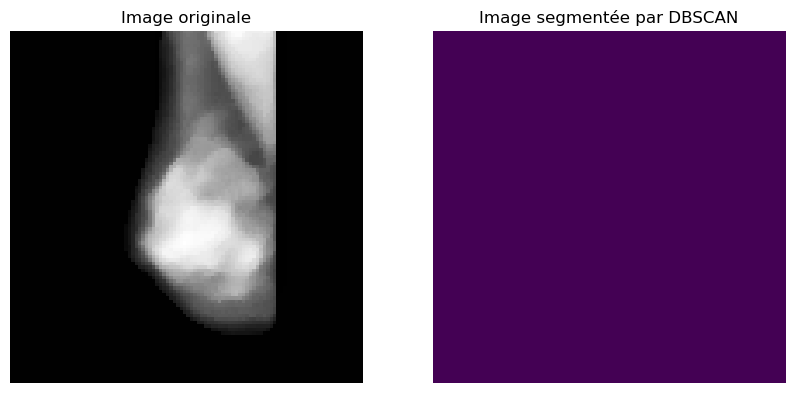

In [3]:
image = breast_images_without_label[0]
height, width = image.shape
reduced_image = cv2.resize(image, (width // 10, height // 10))
#normalized_image = image / 255.0

# Appliquer un filtre médian
filtered_image = median_filter(reduced_image, size=5)  # Taille de la fenêtre = 3x3

# Create a CLAHE object (clipLimit=2.0 and tileGridSize=(8,8) are common default values)
clahe = cv2.createCLAHE(clipLimit=4.0, tileGridSize=(10, 10))

# Apply CLAHE to the grayscale image
clahe_image = clahe.apply(filtered_image)

normalized_image = clahe_image / 255.0

# Paramètres
spatial_weight = 0.1
epsilon = 0.05  # Rayon de voisinage
min_samples = 5  # Nombre minimum de voisins pour être un noyau

# Dimensions de l'image
h, w = normalized_image.shape

# Création des coordonnées spatiales (x, y)
x, y = np.meshgrid(np.arange(w), np.arange(h))
coords = np.stack([x.ravel(), y.ravel()], axis=1)  # Coordonnées des pixels

# Normalisation des coordonnées
coords = coords / np.array([w, h])  # Normaliser entre 0 et 1

# Ajout des valeurs de pixels
pixel_values = normalized_image.ravel().reshape(-1, 1)

# Concaténer les coordonnées normalisées avec les valeurs de pixels
features = np.hstack([coords * spatial_weight, pixel_values])

# Appliquer DBSCAN
dbscan = DBSCAN(eps=epsilon, min_samples=min_samples)
dbscan_labels = dbscan.fit_predict(features)

# Reshape des labels pour avoir l'image segmentée
segmented_image_dbscan = dbscan_labels.reshape(h, w)

# Visualiser l'image segmentée par DBSCAN
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Image originale")
plt.imshow(normalized_image, cmap="gray")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Image segmentée par DBSCAN")
plt.imshow(segmented_image_dbscan, cmap="viridis")  # Utilise une colormap colorée pour visualiser les clusters
plt.axis("off")

plt.show()

In [4]:
image = breast_images_without_label[0]
height, width = image.shape
reduced_image = cv2.resize(image, (width // 15, height // 15))

normalized_image = reduced_image / 255.0

# Paramètres
epsilon = 0.05  # Rayon de voisinage
min_samples = 5  # Nombre minimum de voisins pour être un noyau

pixel_values = normalized_image.ravel().reshape(-1, 1)

In [9]:
pixel_values.shape

(4624, 1)

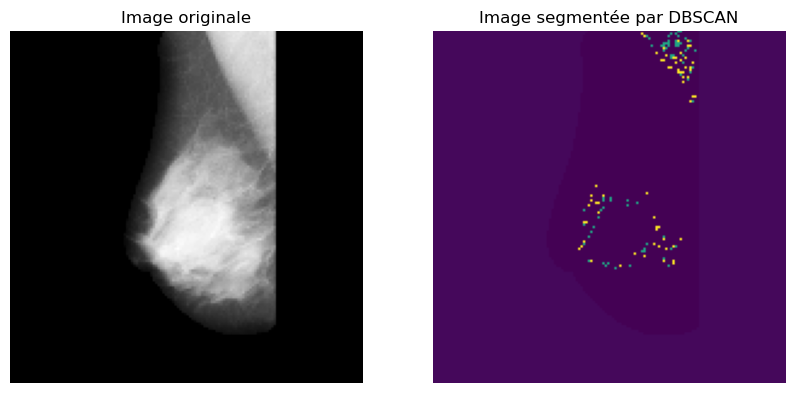

In [40]:
image = breast_images_without_label[0]
height, width = image.shape
factor = 7
reduced_image = cv2.resize(image, (width // factor, height // factor))

new_width, new_height = width // factor, height //factor

# Paramètres
epsilon = 0.5  # Rayon de voisinage
min_samples = 2  # Nombre minimum de voisins pour être un noyau

pixel_values = reduced_image.reshape(-1, 1)

# Appliquer DBSCAN
dbscan = DBSCAN(eps=epsilon, min_samples=min_samples)
dbscan_labels = dbscan.fit_predict(pixel_values)

# Reshape des labels pour avoir l'image segmentée
#segmented_image_dbscan = dbscan_labels.reshape(new_height, new_width)

# Comptabiliser les labels
unique_labels, counts = np.unique(dbscan_labels, return_counts=True)

# Trier par taille et garder les 3 premiers clusters (exclure le bruit -1)
sorted_labels = sorted(zip(unique_labels, counts), key=lambda x: x[1], reverse=True)
top_3_labels = [label for label, _ in sorted_labels[:3]]

# Replacer les labels autres que les 3 premiers par -1 (bruit)
dbscan_labels_filtered = np.where(np.isin(dbscan_labels, top_3_labels), dbscan_labels, -1)

# Reshape pour l'image segmentée
segmented_image_dbscan = dbscan_labels_filtered.reshape(new_height, new_width)

# Visualiser l'image segmentée par DBSCAN
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Image originale")
plt.imshow(reduced_image, cmap="gray")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Image segmentée par DBSCAN")
plt.imshow(segmented_image_dbscan, cmap="viridis")  # Utilise une colormap colorée pour visualiser les clusters
plt.axis("off")

plt.show()

In [36]:
print(np.unique(dbscan_labels))  # Voir les labels uniques retournés par DBSCAN

[ -1   0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16
  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34
  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52
  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70
  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88
  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106
 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124
 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142
 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160
 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178
 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196
 197 198 199 200 201 202]


# Dilatation

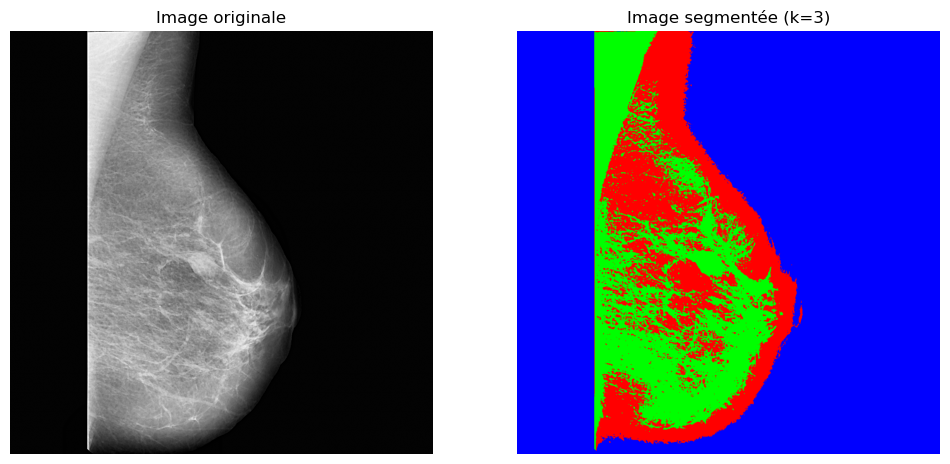

In [162]:
image = breast_images_without_label[11]
h,w = image.shape

# ---------------------------------- Filtres --------------------------------- #
# Appliquer un filtre médian
filtered_image = median_filter(image, size=3)  # Taille de la fenêtre = 3x3

# Create a CLAHE object (clipLimit=2.0 and tileGridSize=(8,8) are common default values)
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))

# Apply CLAHE to the grayscale image
clahe_image = clahe.apply(filtered_image)

# Apply unsharp masking
sharpened_image = unsharp_mask(clahe_image, radius=2, amount=1.5)

normalized_image = sharpened_image / 255.0

# Ajout des valeurs de pixels
pixel_values = normalized_image.reshape(-1, 1)

# ---------------------------------- K-Means --------------------------------- #
# Appliquer K-Means sur les nouvelles caractéristiques
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(pixel_values)

# Reshape des labels pour l'image segmentée
segmented_image = kmeans.labels_.reshape(h, w)


# --------------------------------- Affichage -------------------------------- #
# Définir manuellement les couleurs pour chaque label
# Par exemple, tu peux choisir trois couleurs distinctes : rouge, vert, bleu
cluster_colors = {
    0: [1, 0, 0],  # Rouge
    1: [0, 1, 0],  # Vert
    2: [0, 0, 1],  # Bleu
}

# Créer une image avec les couleurs manuelles pour chaque label
colored_segmented_image = np.zeros((h, w, 3))  # Image RGB vide

for label in range(n_clusters):
    colored_segmented_image[segmented_image == label] = cluster_colors[label]

# Trouver les centres des clusters
# Visualiser l'image segmentée
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.title("Image originale")
plt.imshow(normalized_image, cmap="gray")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title(f"Image segmentée (k={n_clusters})")
plt.imshow(colored_segmented_image)  # Utilise une colormap colorée pour visualiser les clusters
plt.axis("off")

plt.show()

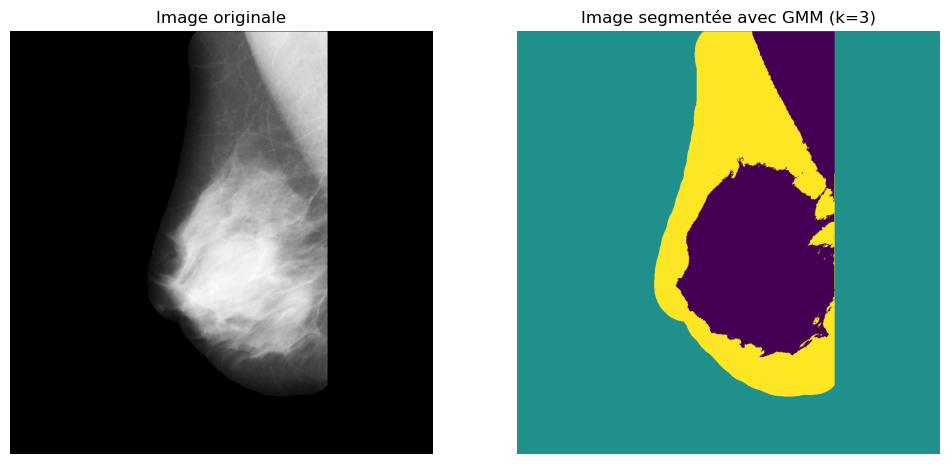

In [182]:
image = breast_images_without_label[0]
# Normaliser l'image (optionnel si elle est déjà dans l'intervalle [0, 1])
image_normalized = image / 255.0

# Dimensions de l'image
h, w = image_normalized.shape

# Créer une grille de coordonnées (x, y)
x, y = np.meshgrid(np.arange(w), np.arange(h))
coords = np.stack([x.ravel(), y.ravel()], axis=1)  # Coordonnées des pixels

coords = coords / np.array([w, h])

# Ajouter les valeurs de pixels (intensité de l'image)
pixel_values = image_normalized.ravel().reshape(-1, 1)

# Concaténer les coordonnées (x, y) avec l'intensité du pixel
factor = 0.1
features = np.hstack([factor * coords, pixel_values])

# Appliquer GMM avec 3 composantes
n_components = 3
gmm = GaussianMixture(n_components=n_components, random_state=42, covariance_type="diag")
gmm.fit(features)

# Prédire les labels de chaque pixel
labels = gmm.predict(features)

# Reshaper les labels pour créer l'image segmentée
segmented_image = labels.reshape(h, w)

# Visualiser l'image originale et l'image segmentée
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(image_normalized, cmap='gray')
plt.title("Image originale")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(segmented_image, cmap='viridis')
plt.title(f"Image segmentée avec GMM (k={n_components})")
plt.axis("off")

plt.show()

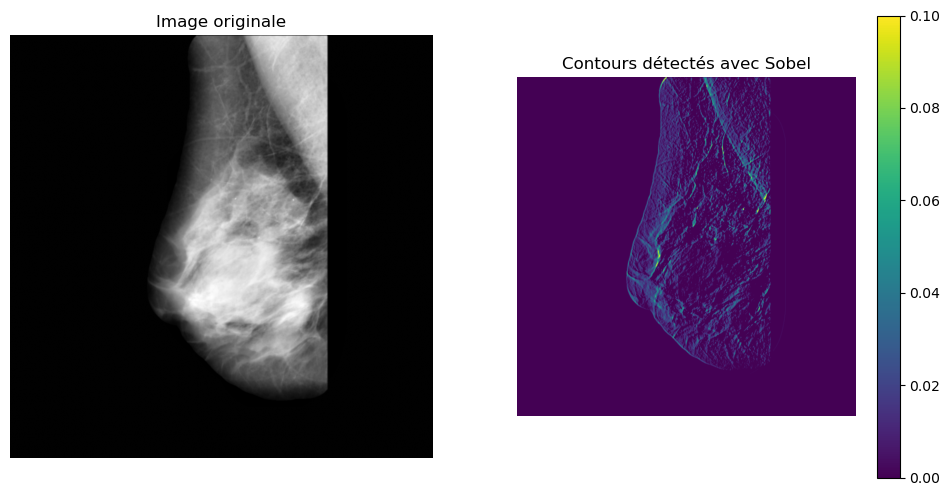

In [212]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color
from skimage.filters import sobel, gaussian
import cv2

# Charger l'image
image = breast_images_without_label[0]  # Remplacez par le chemin de votre image

# Create a CLAHE object (clipLimit=2.0 and tileGridSize=(8,8) are common default values)
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))

# Appliquer CLAHE à l'image en niveaux de gris
clahe_image = clahe.apply(image)

# Appliquer un flou gaussien pour réduire le bruit
image_blurred = gaussian(clahe_image, sigma=1)

# Appliquer le filtre de Sobel pour détecter les contours
edges = sobel(image_blurred, axis=1)

# Visualiser l'image originale et les contours détectés
plt.figure(figsize=(12, 6))

# Afficher l'image originale
plt.subplot(1, 2, 1)
plt.title("Image originale")
plt.imshow(image_blurred, cmap="gray")
plt.axis("off")

# Afficher les contours détectés avec Sobel
plt.subplot(1, 2, 2)
plt.title("Contours détectés avec Sobel")
plt.imshow(edges, vmin=0, vmax=0.1)
plt.colorbar()
plt.axis("off")

plt.show()

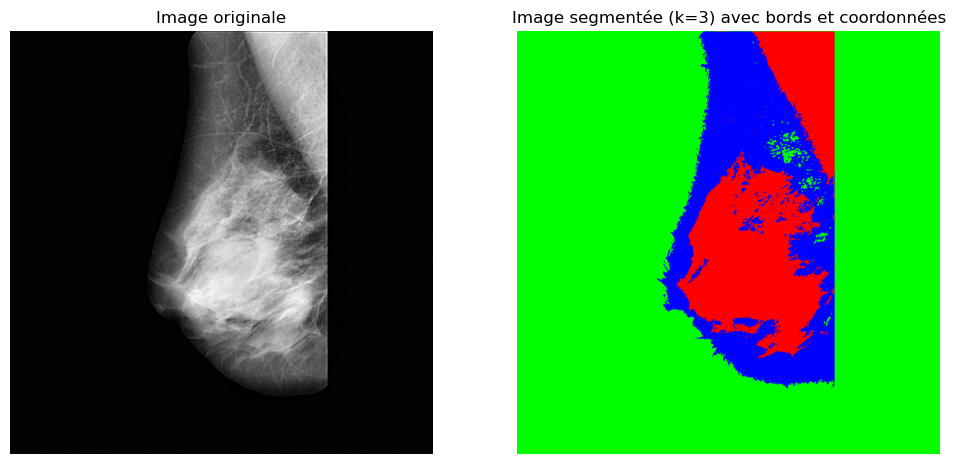

In [317]:
from skimage.filters import sobel

# Charger l'image
image = breast_images_without_label[0]
h, w = image.shape

# ---------------------------------- Filtres --------------------------------- #
# Appliquer un filtre médian
filtered_image = median_filter(image, size=3)  # Taille de la fenêtre = 3x3

# Create a CLAHE object (clipLimit=2.0 and tileGridSize=(8,8) are common default values)
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))

# Appliquer CLAHE à l'image en niveaux de gris
clahe_image = clahe.apply(filtered_image)

# Appliquer unsharp masking pour affiner l'image
sharpened_image = unsharp_mask(clahe_image, radius=2, amount=1.5)

# Normaliser l'image
normalized_image = sharpened_image / 255.0

# Appliquer le filtre de Sobel pour détecter les bords
edges_factor = 2
edges = sobel(normalized_image, axis=0)

# ---------------------------------- Coordonnées des pixels --------------------------------- #

# Création des coordonnées spatiales (x, y)
x, y = np.meshgrid(np.arange(w), np.arange(h))
coords = np.stack([x.ravel(), y.ravel()], axis=1)  # Coordonnées des pixels

# Normalisation des coordonnées
coords = coords / np.array([w, h])  # Normaliser entre 0 et 1

# Ajout des valeurs de pixels
pixel_values = normalized_image.reshape(-1, 1)

# Concaténer les coordonnées normalisées avec les valeurs de pixels
spatial_weight = 0.0001  # Donne moins d'importance aux coordonnées

# ---------------------------------- K-Means --------------------------------- #

# Redimensionner les images et les coordonnées pour avoir une seule dimension de pixels
pixel_values = np.stack([pixel_values.reshape(-1), edges_factor*edges.reshape(-1),
                         spatial_weight*coords[:,0], spatial_weight*coords[:,1]], axis=1)

# Appliquer K-Means sur les nouvelles caractéristiques (image + bords + coordonnées)
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(pixel_values)

# Reshape des labels pour l'image segmentée
segmented_image = kmeans.labels_.reshape(h, w)

# --------------------------------- Affichage -------------------------------- #
# Définir manuellement les couleurs pour chaque label
cluster_colors = {
    0: [1, 0, 0],  # Rouge
    1: [0, 1, 0],  # Vert
    2: [0, 0, 1],  # Bleu
}

# Créer une image avec les couleurs manuelles pour chaque label
colored_segmented_image = np.zeros((h, w, 3))  # Image RGB vide

for label in range(n_clusters):
    colored_segmented_image[segmented_image == label] = cluster_colors[label]

# Visualiser l'image segmentée
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.title("Image originale")
plt.imshow(normalized_image, cmap="gray")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title(f"Image segmentée (k={n_clusters}) avec bords et coordonnées")
plt.imshow(colored_segmented_image)  # Affiche les segments avec les couleurs associées
plt.axis("off")

plt.show()

C:\Users\planc\AppData\Local\Temp\ipykernel_15916\3049838225.py:27: FutureWarning: `square` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  selem1 = morphology.square(45)  # Structuring element, here a 3x3 square


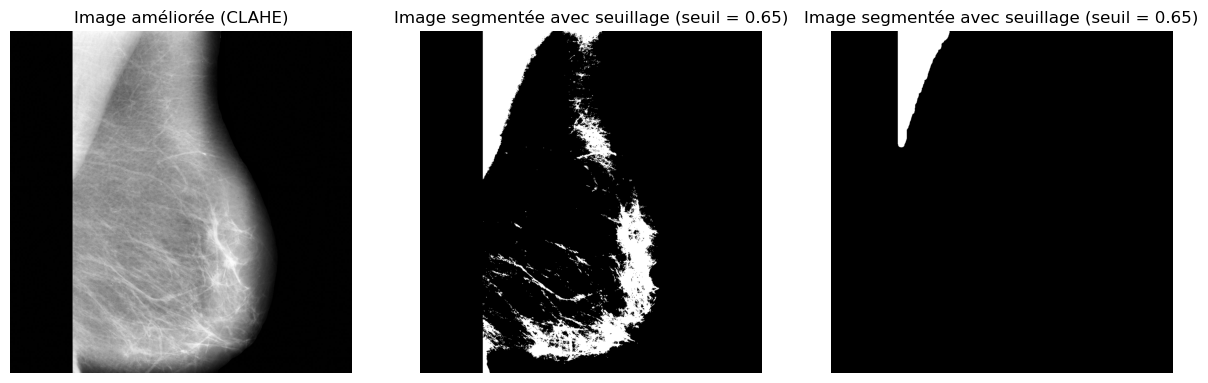

In [373]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, exposure
from skimage.morphology import remove_small_objects
import cv2

# Charger l'image (à remplacer par l'image de votre choix)
image = breast_images_without_label[5]  # Remplacez par votre image

# ---------------------------------- Amélioration du contraste --------------------------------- #
# Utilisation de CLAHE (Contrast Limited Adaptive Histogram Equalization)
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
enhanced_image = clahe.apply(image)

# Normalisation pour la visualisation
normalized_image = enhanced_image / 255.0

# ---------------------------------- Seuillage basé sur l'intensité --------------------------------- #
# Appliquer un seuillage simple basé sur l'intensité des pixels
# Par exemple, on peut définir un seuil manuellement
threshold_value = 0.65  # Valeur de seuil (comprise entre 0 et 1 après normalisation)

# Seuillage : les pixels avec une valeur supérieure au seuil deviennent 1 (blanc), les autres deviennent 0 (noir)
binary_segmented_image = normalized_image > threshold_value

# Apply erosion and dilation
selem1 = morphology.square(45)  # Structuring element, here a 3x3 square
eroded_image = morphology.erosion(binary_segmented_image, selem1)

selem2 = morphology.disk(10)
dilated_image = morphology.dilation(eroded_image, selem2)

# Convert the binary results back to an image
dilated_image = img_as_ubyte(dilated_image)

# --------------------------------- Affichage -------------------------------- #
# Visualiser l'image avant et après l'amélioration du contraste et du seuillage
plt.figure(figsize=(15, 6))

# Afficher l'image originale
plt.subplot(1, 3, 1)
plt.title("Image améliorée (CLAHE)")
plt.imshow(normalized_image, cmap="gray")
plt.axis("off")

# Afficher l'image segmentée par seuillage
plt.subplot(1, 3, 2)
plt.title(f"Image segmentée avec seuillage (seuil = {threshold_value})")
plt.imshow(binary_segmented_image, cmap="gray")
plt.axis("off")

# Afficher l'image segmentée par seuillage
plt.subplot(1, 3, 3)
plt.title(f"Image segmentée avec seuillage (seuil = {threshold_value})")
plt.imshow(dilated_image, cmap="gray")
plt.axis("off")

plt.show()


# Morpho OK

C:\Users\planc\AppData\Local\Temp\ipykernel_15916\1437048431.py:20: FutureWarning: `square` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  selem1 = morphology.square(40)  # Structuring element, here a 3x3 square


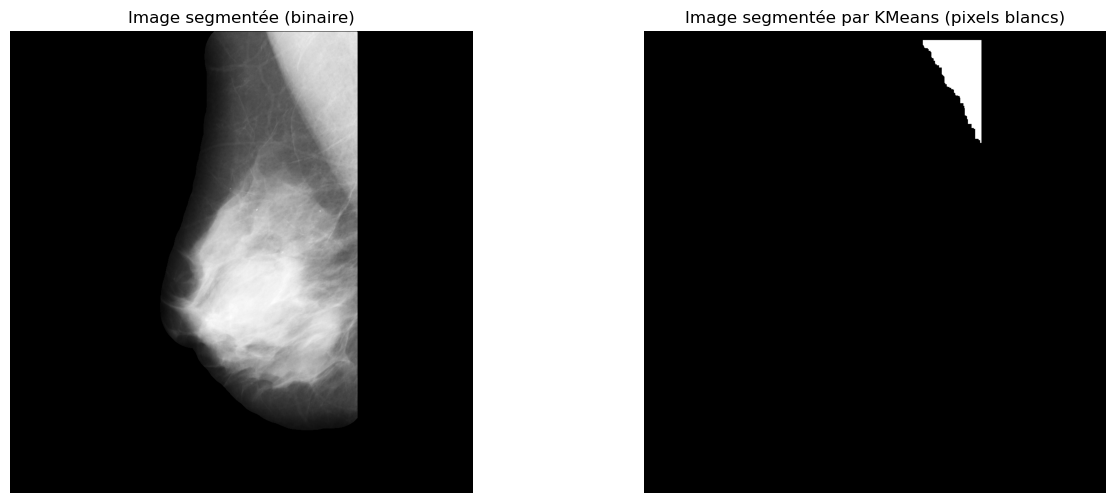

C:\Users\planc\AppData\Local\Temp\ipykernel_15916\1437048431.py:20: FutureWarning: `square` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  selem1 = morphology.square(40)  # Structuring element, here a 3x3 square


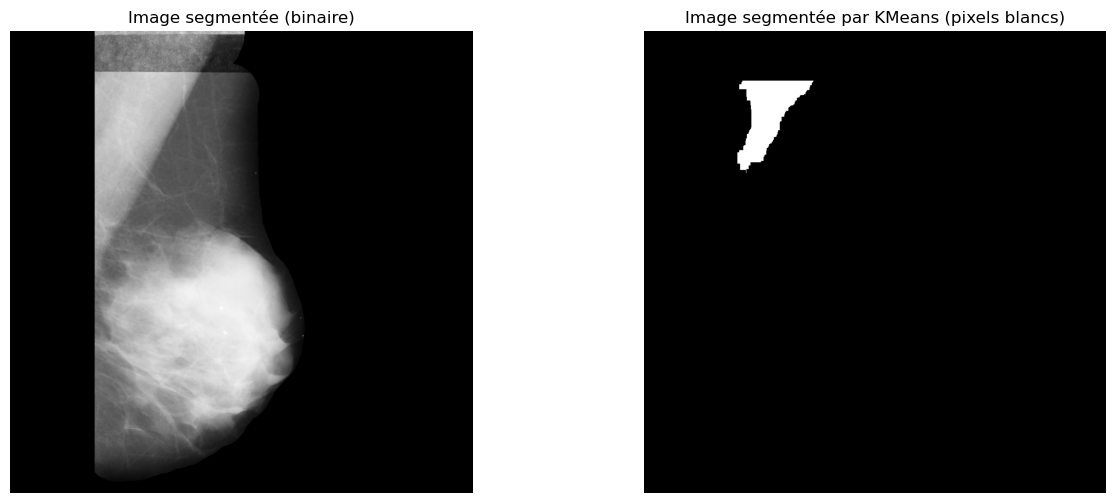

C:\Users\planc\AppData\Local\Temp\ipykernel_15916\1437048431.py:20: FutureWarning: `square` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  selem1 = morphology.square(40)  # Structuring element, here a 3x3 square


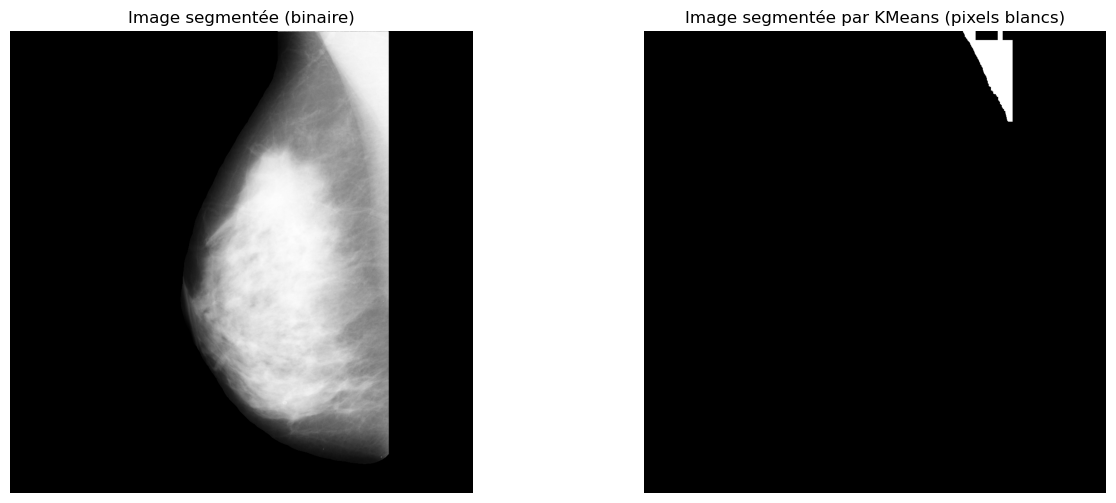

C:\Users\planc\AppData\Local\Temp\ipykernel_15916\1437048431.py:20: FutureWarning: `square` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  selem1 = morphology.square(40)  # Structuring element, here a 3x3 square


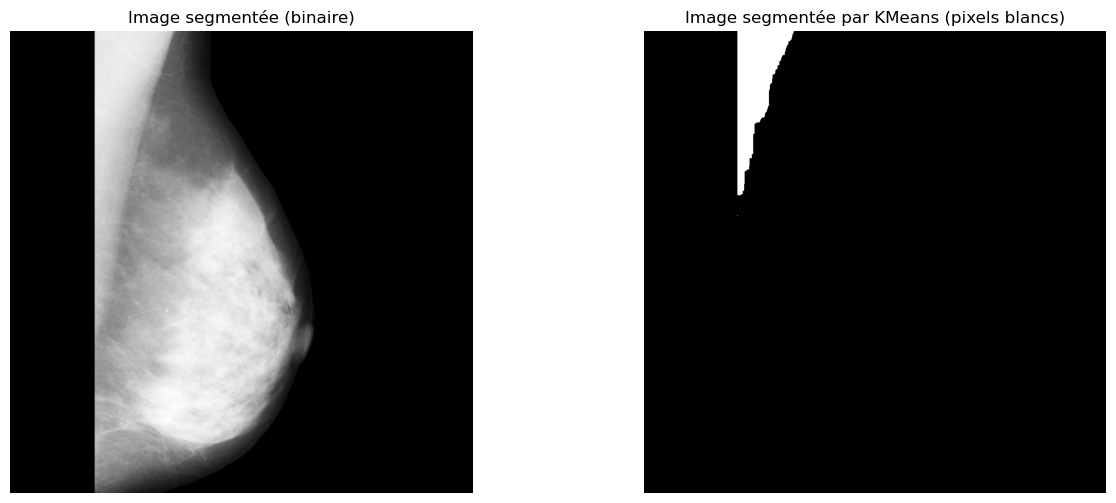

C:\Users\planc\AppData\Local\Temp\ipykernel_15916\1437048431.py:20: FutureWarning: `square` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  selem1 = morphology.square(40)  # Structuring element, here a 3x3 square


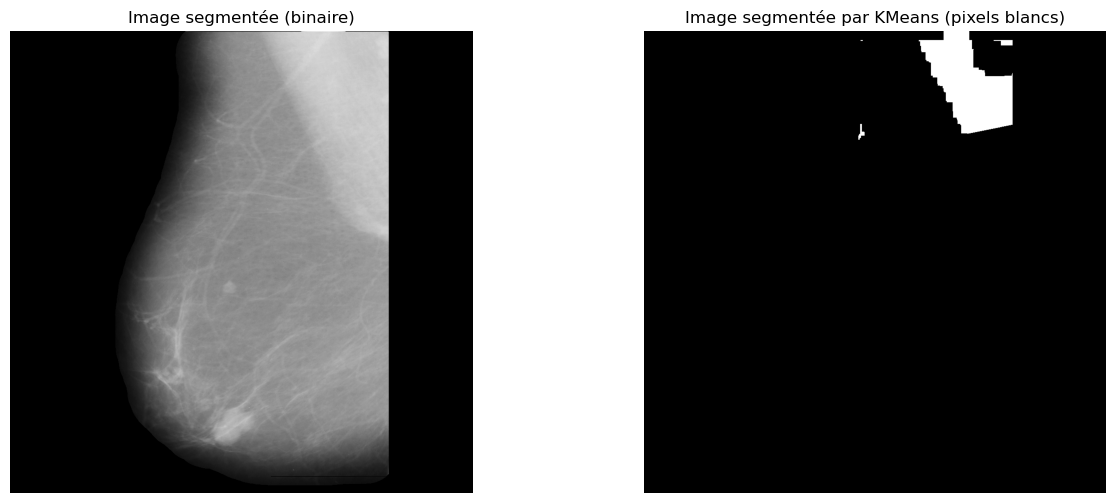

C:\Users\planc\AppData\Local\Temp\ipykernel_15916\1437048431.py:20: FutureWarning: `square` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  selem1 = morphology.square(40)  # Structuring element, here a 3x3 square


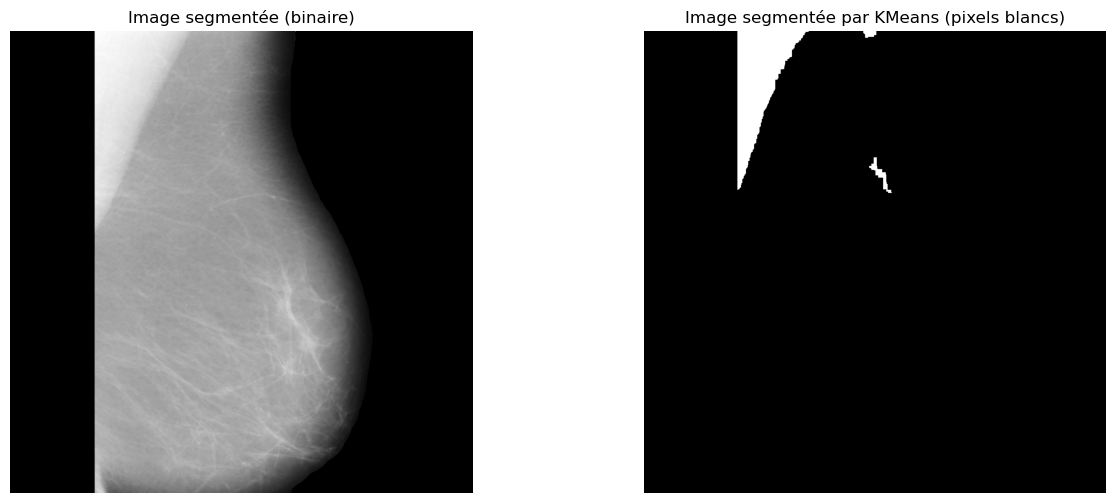

C:\Users\planc\AppData\Local\Temp\ipykernel_15916\1437048431.py:20: FutureWarning: `square` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  selem1 = morphology.square(40)  # Structuring element, here a 3x3 square


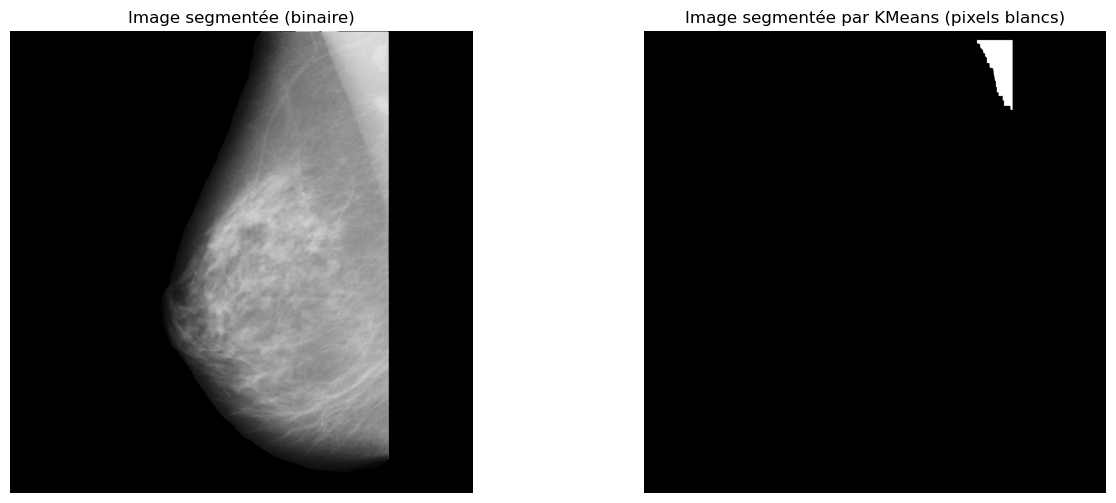

C:\Users\planc\AppData\Local\Temp\ipykernel_15916\1437048431.py:20: FutureWarning: `square` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  selem1 = morphology.square(40)  # Structuring element, here a 3x3 square


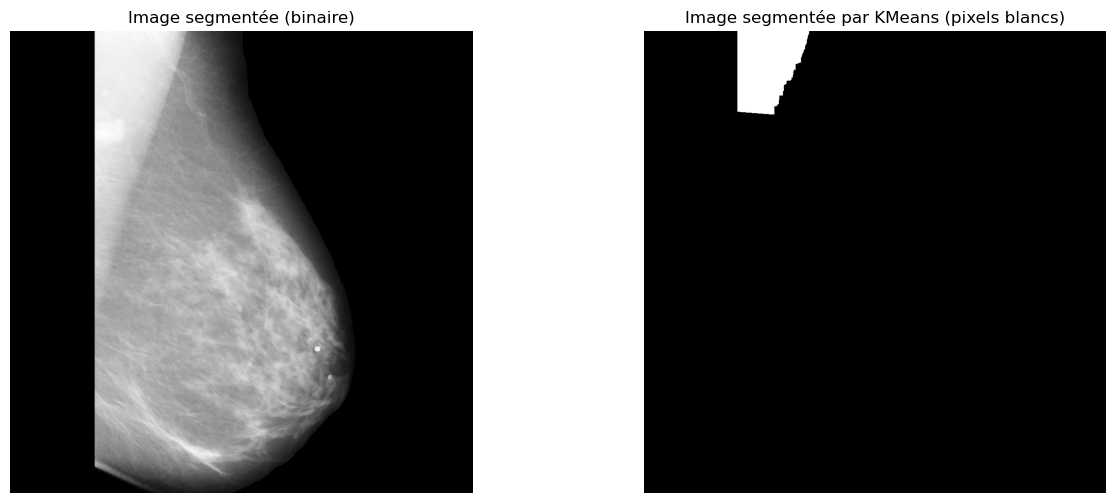

C:\Users\planc\AppData\Local\Temp\ipykernel_15916\1437048431.py:20: FutureWarning: `square` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  selem1 = morphology.square(40)  # Structuring element, here a 3x3 square


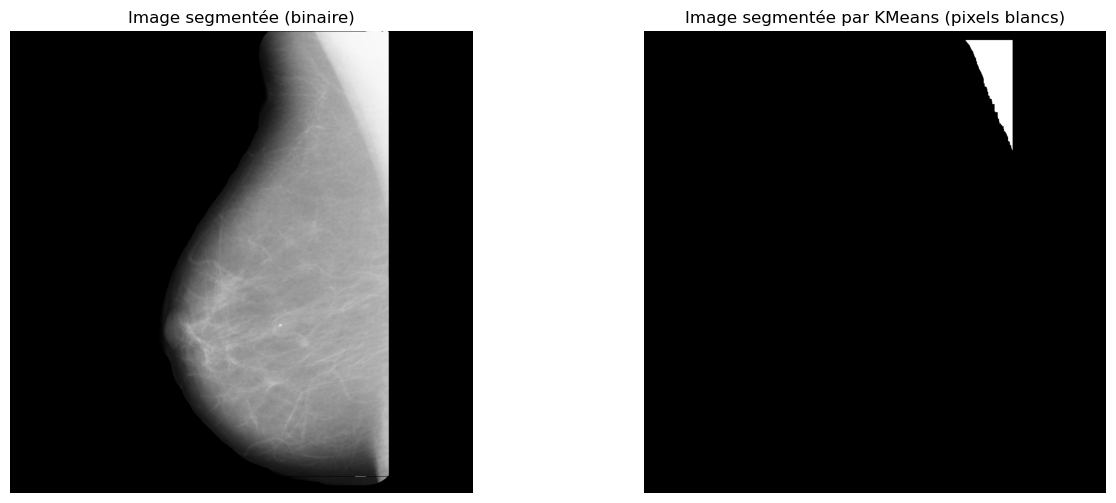

C:\Users\planc\AppData\Local\Temp\ipykernel_15916\1437048431.py:20: FutureWarning: `square` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  selem1 = morphology.square(40)  # Structuring element, here a 3x3 square


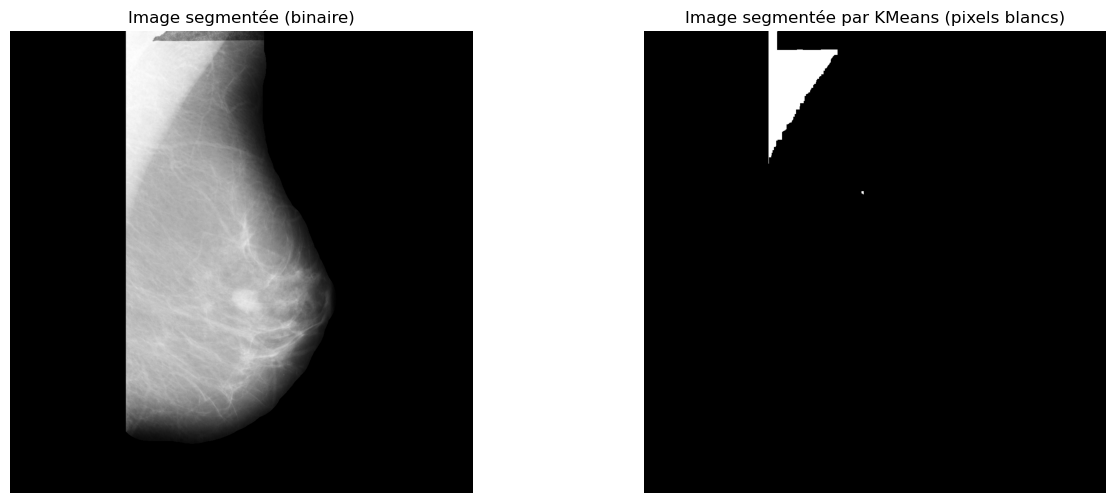

C:\Users\planc\AppData\Local\Temp\ipykernel_15916\1437048431.py:20: FutureWarning: `square` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  selem1 = morphology.square(40)  # Structuring element, here a 3x3 square


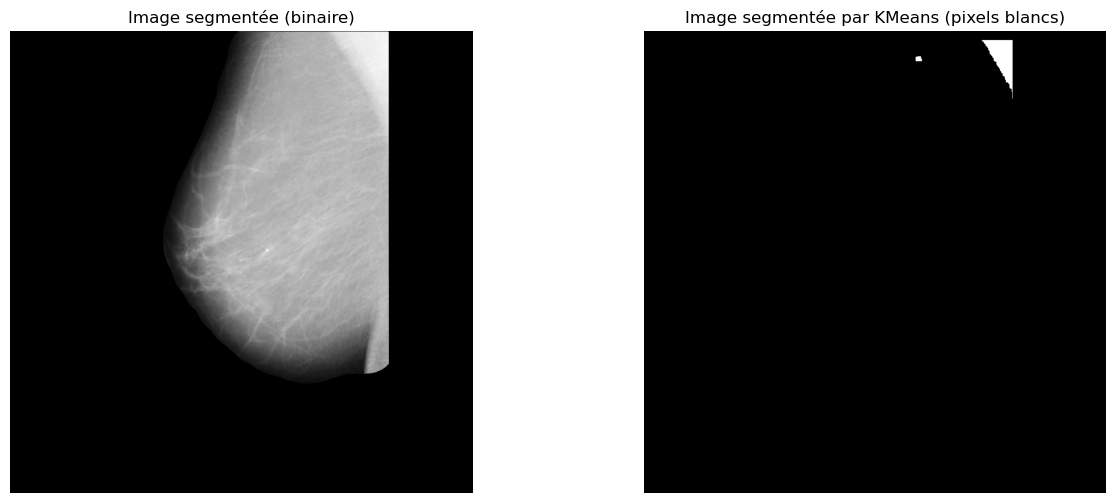

C:\Users\planc\AppData\Local\Temp\ipykernel_15916\1437048431.py:20: FutureWarning: `square` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  selem1 = morphology.square(40)  # Structuring element, here a 3x3 square


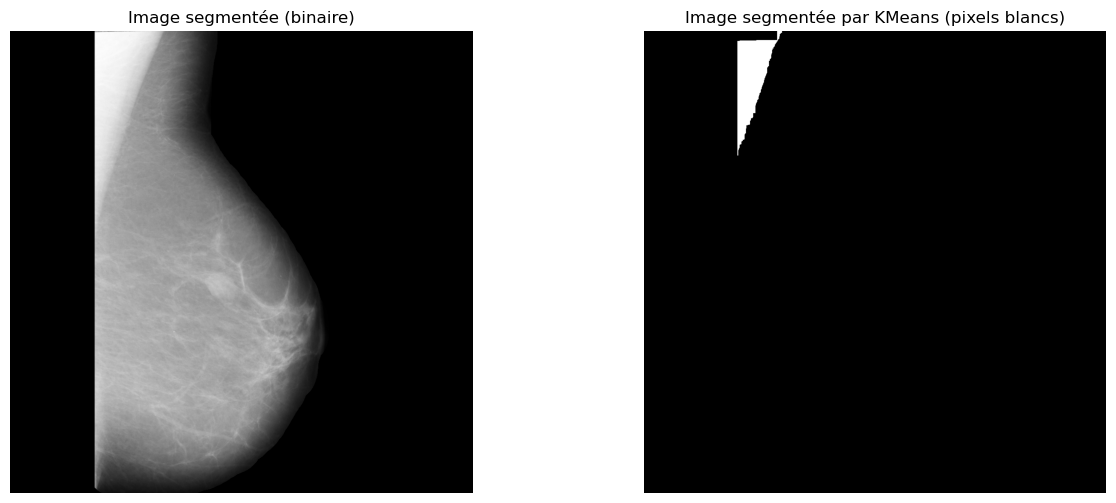

C:\Users\planc\AppData\Local\Temp\ipykernel_15916\1437048431.py:20: FutureWarning: `square` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  selem1 = morphology.square(40)  # Structuring element, here a 3x3 square


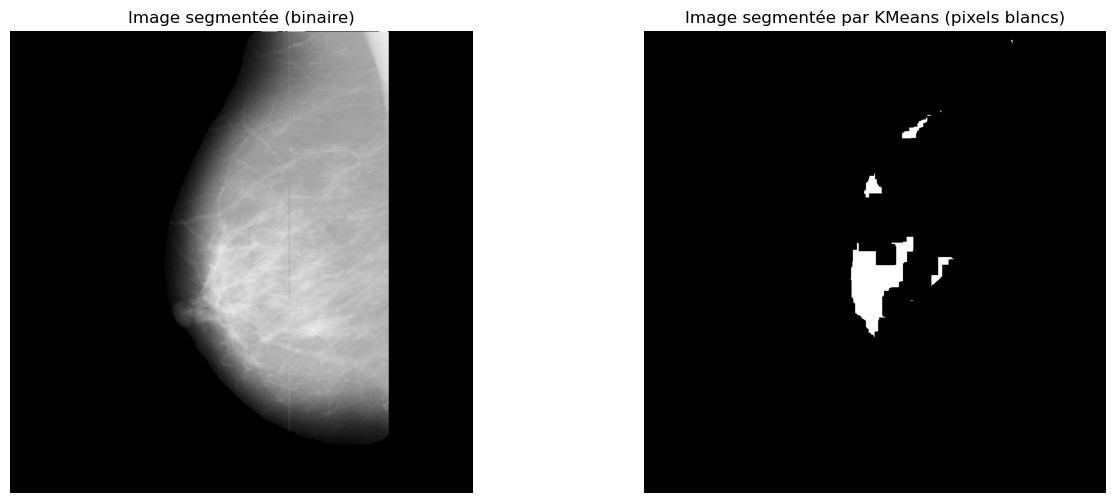

C:\Users\planc\AppData\Local\Temp\ipykernel_15916\1437048431.py:20: FutureWarning: `square` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  selem1 = morphology.square(40)  # Structuring element, here a 3x3 square


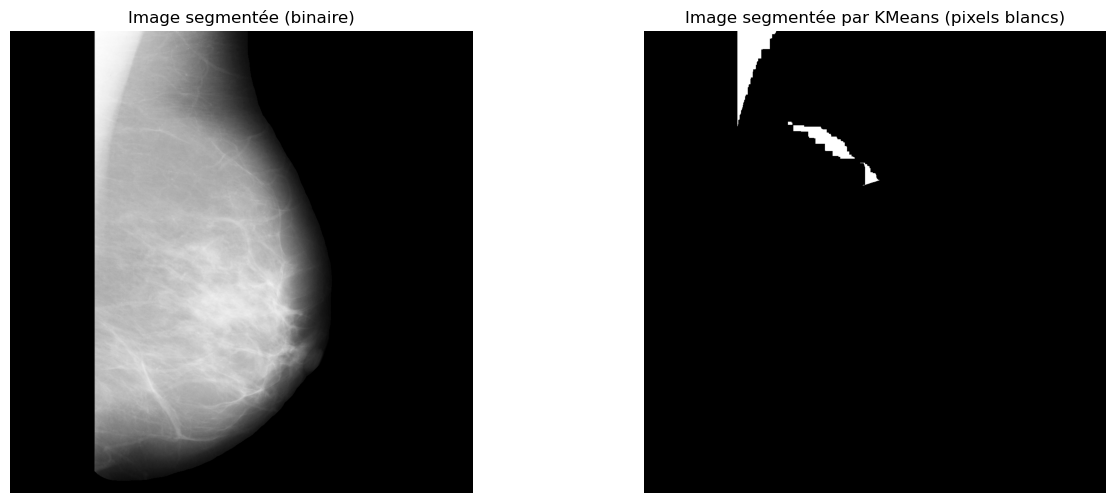

C:\Users\planc\AppData\Local\Temp\ipykernel_15916\1437048431.py:20: FutureWarning: `square` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  selem1 = morphology.square(40)  # Structuring element, here a 3x3 square


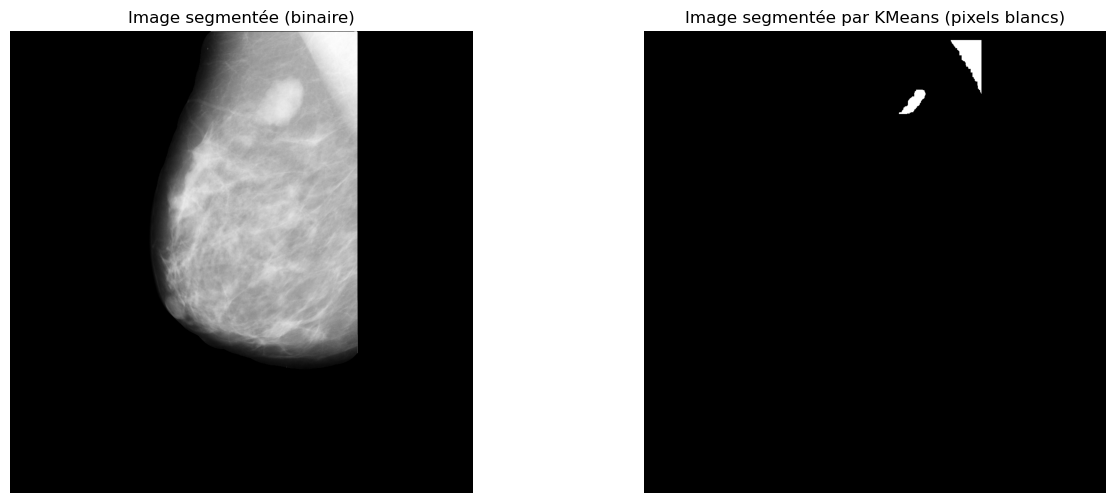

In [485]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, exposure
from skimage.morphology import remove_small_objects
import cv2
from sklearn.cluster import KMeans

def get_pectoral_mask(image):

    # ---------------------------------- Amélioration du contraste --------------------------------- #
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced_image = clahe.apply(image)
    normalized_image = enhanced_image / 255.0

    # ---------------------------------- Seuillage basé sur l'intensité --------------------------------- #
    threshold_value = 0.6  # Valeur de seuil
    binary_segmented_image = normalized_image > threshold_value

    # Apply erosion and dilation
    selem1 = morphology.square(40)  # Structuring element, here a 3x3 square
    binary_segmented_image = morphology.erosion(binary_segmented_image, selem1)

    # ---------------------------------- Filtrer les pixels blancs --------------------------------- #
    # Récupérer les coordonnées et intensités des pixels blancs (seuil passé)
    white_pixel_coords = np.column_stack(np.where(binary_segmented_image))  # Coordonnées (y, x)
    white_pixel_intensities = normalized_image[binary_segmented_image]  # Intensités des pixels

    # Concaténer position et intensité pour KMeans
    features = np.hstack([white_pixel_coords, white_pixel_intensities[:, None]])  # [y, x, intensité]

    # ---------------------------------- Appliquer KMeans --------------------------------- #
    # Appliquer KMeans sur les pixels blancs (par exemple, 3 clusters)
    n_clusters = 2
    kmeans = KMeans(n_clusters=n_clusters, random_state=0, init="random")
    kmeans.fit(features)

    # Labels des clusters pour les pixels blancs
    cluster_labels = kmeans.labels_

    # ---------------------------------- Reconstruction de l'image segmentée --------------------------------- #
    segmented_image = np.zeros_like(binary_segmented_image, dtype=int)  # Image vide
    segmented_image[binary_segmented_image] = cluster_labels + 1  # Remplir avec les clusters (labels)

    mask = np.zeros_like(segmented_image)
    mask[segmented_image == 1] = 1

    mask = np.zeros_like(binary_segmented_image, dtype=int)
    mask[binary_segmented_image] = (cluster_labels == 0).astype(int) # avecle random dans le kmeans, le triangle pectoral est toujours l'indice 0

    return mask


for i in range (15):
    image = breast_images_without_label[i]
    mask = get_pectoral_mask(image)
    # ---------------------------------- Affichage --------------------------------- #
    plt.figure(figsize=(15, 6))

    # Image binaire segmentée (avant KMeans)
    plt.subplot(1, 2, 1)
    plt.title("Image segmentée (binaire)")
    plt.imshow(image, cmap="gray")
    plt.axis("off")

    # Image après KMeans
    plt.subplot(1, 2, 2)
    plt.title("Image segmentée par KMeans (pixels blancs)")
    plt.imshow(mask, cmap="grey")  # Affichage des clusters
    plt.axis("off")

    plt.show()


# Filter + Kmeans

In [181]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, exposure
from skimage.morphology import remove_small_objects
import cv2
from sklearn.cluster import KMeans
from collections import Counter

In [178]:
def dominant_label_weighted(cluster_labels, white_pixel_coords, image_shape):
    """
    Trouve le label dominant en pondérant chaque ligne : les lignes du haut ont un poids plus élevé.

    Parameters:
        cluster_labels (array): Les labels de chaque pixel blanc.
        white_pixel_coords (array): Coordonnées (y, x) des pixels blancs.
        image_shape (tuple): Shape (hauteur, largeur) de l'image originale.

    Returns:
        int or None: Le label dominant en fonction de la hauteur pondérée, en ignorant le label 0.
    """
    height, _ = image_shape  # Hauteur de l'image

    # Calcul des poids : ligne du haut = poids max, ligne du bas = poids min
    weights = 1 - (white_pixel_coords[:, 0] / height)  # Poids décroissant de 1 en haut à 0 en bas

    # Filtrer les labels différents de 0
    valid_mask = cluster_labels != 0
    valid_labels = cluster_labels[valid_mask]
    valid_weights = weights[valid_mask]

    if len(valid_labels) == 0:
        return None  # Aucun pixel valide

    # Somme des poids pour chaque label
    weighted_counts = {}
    for label, weight in zip(valid_labels, valid_weights):
        weighted_counts[label] = weighted_counts.get(label, 0) + weight

    # Trouver le label avec le poids total le plus élevé
    dominant_label = max(weighted_counts, key=weighted_counts.get)

    return dominant_label + 1

In [186]:
def get_pectoral_mask(image):
    n, d = image.shape
    # ---------------------------------- Amélioration du contraste --------------------------------- #
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced_image = clahe.apply(image)
    enhanced_image = np.reshape(enhanced_image, (n,d))

    # ---------------------------------- Filtrer les pixels blancs --------------------------------- #
    # Récupérer les coordonnées et intensités des pixels blancs (seuil passé)
    white_pixel_coords = np.column_stack(np.where(enhanced_image > 180))  # Coordonnées (y, x)

    # ---------------------------------- Appliquer KMeans --------------------------------- #
    # Appliquer KMeans sur les pixels blancs (par exemple, 3 clusters)
    n_clusters = 2
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    kmeans.fit(white_pixel_coords)

    # Labels des clusters pour les pixels blancs
    cluster_labels = kmeans.labels_

    # ---------------------------------- Créer une image des clusters --------------------------------- #
    cluster_image = np.zeros_like(image)  # Image vide (même taille que l'originale)
    cluster_image[white_pixel_coords[:, 0], white_pixel_coords[:, 1]] = cluster_labels + 1  # + 1 pour éviter le 0

    dom_label = dominant_label_weighted(cluster_labels, white_pixel_coords, image.shape)

    pectoral_mask = np.where(cluster_image == dom_label, cluster_image, 0)

    return enhanced_image, pectoral_mask

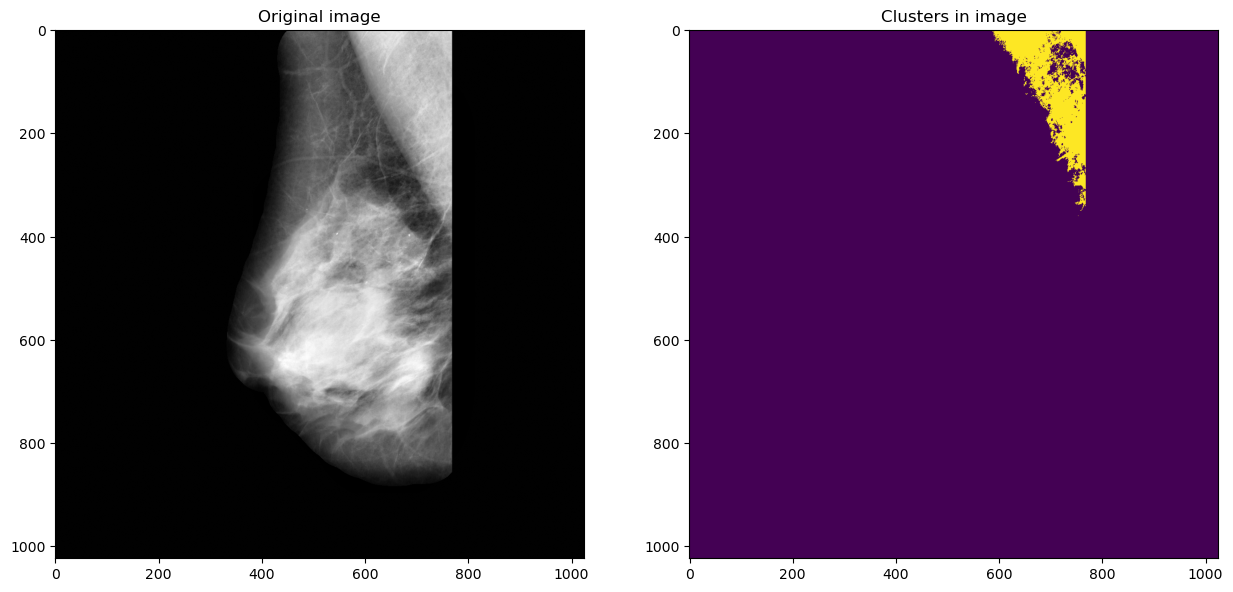

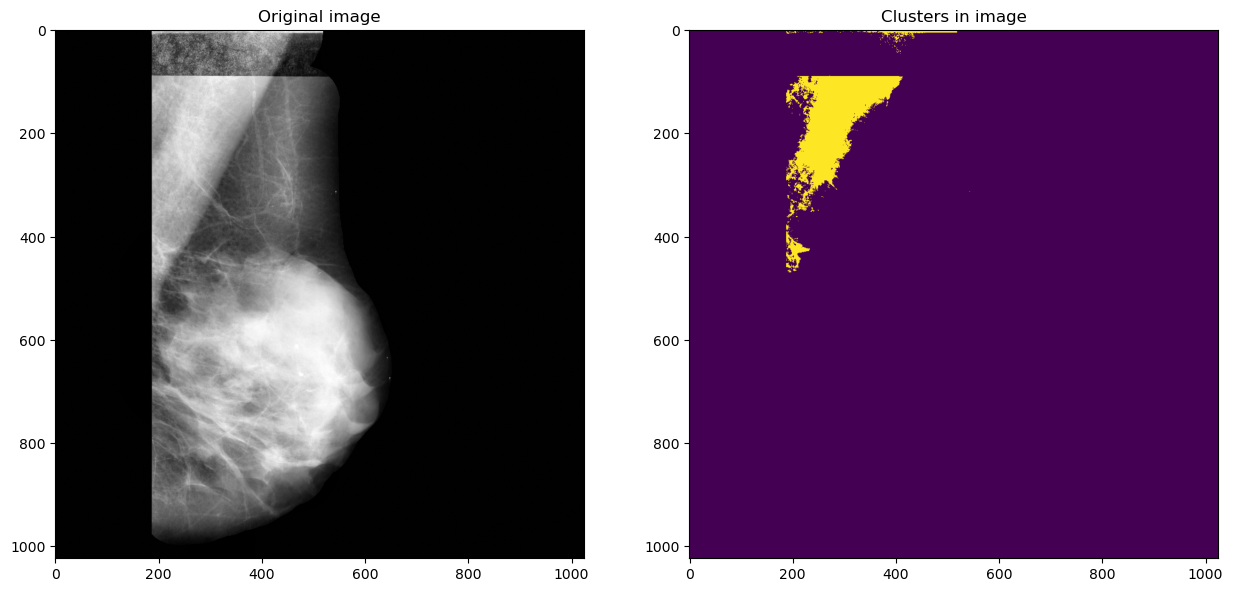

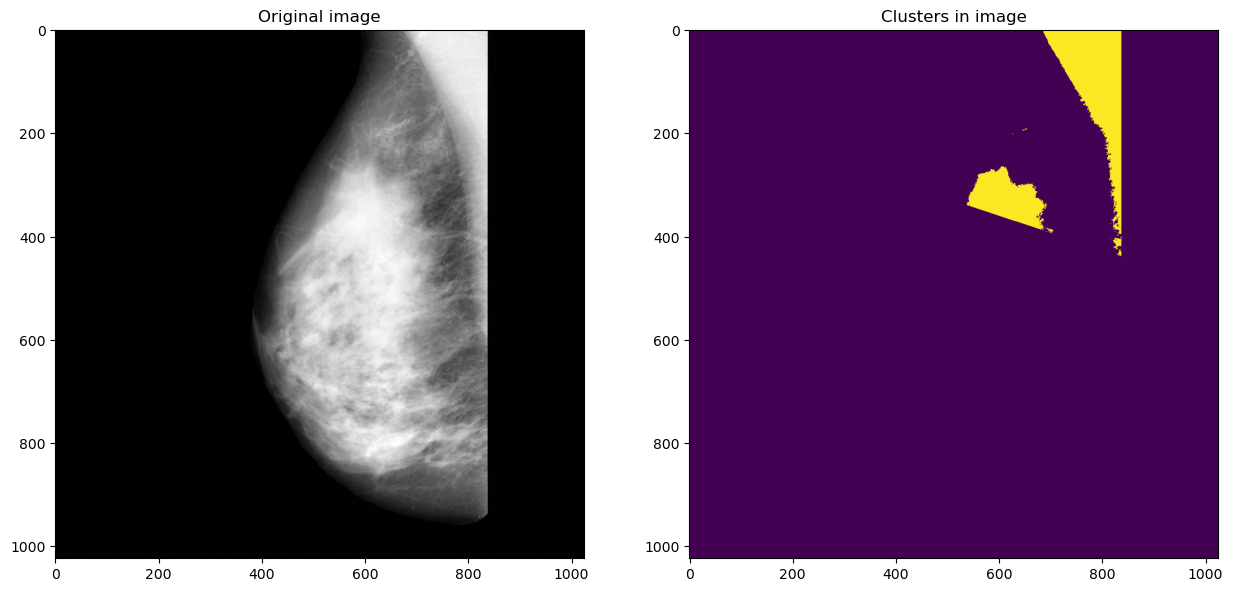

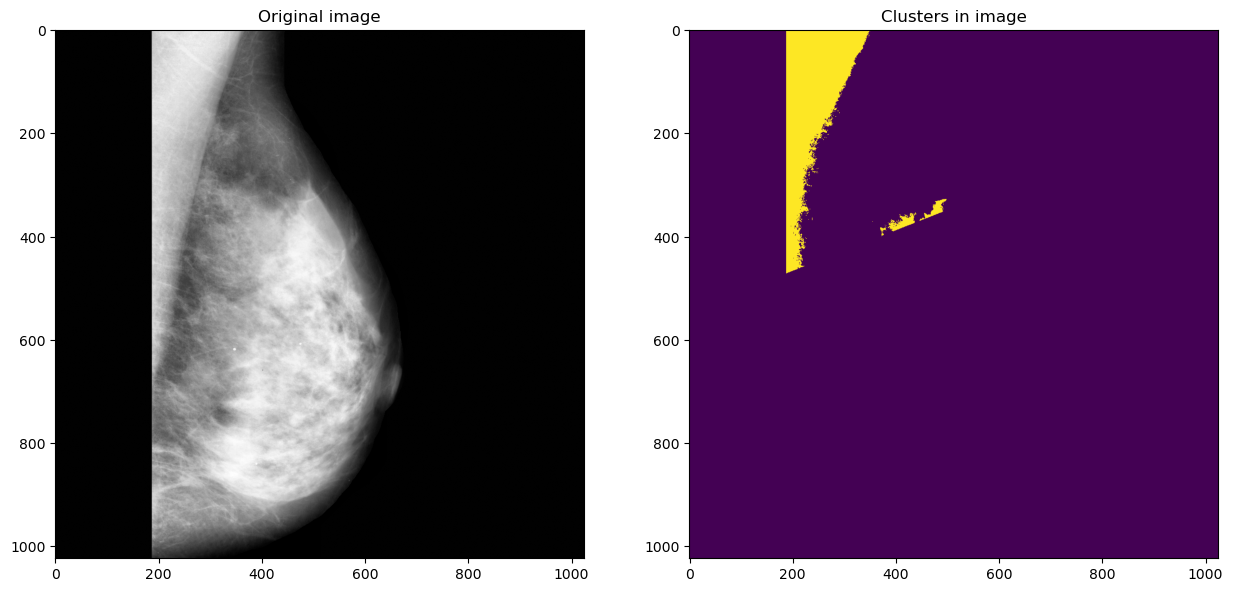

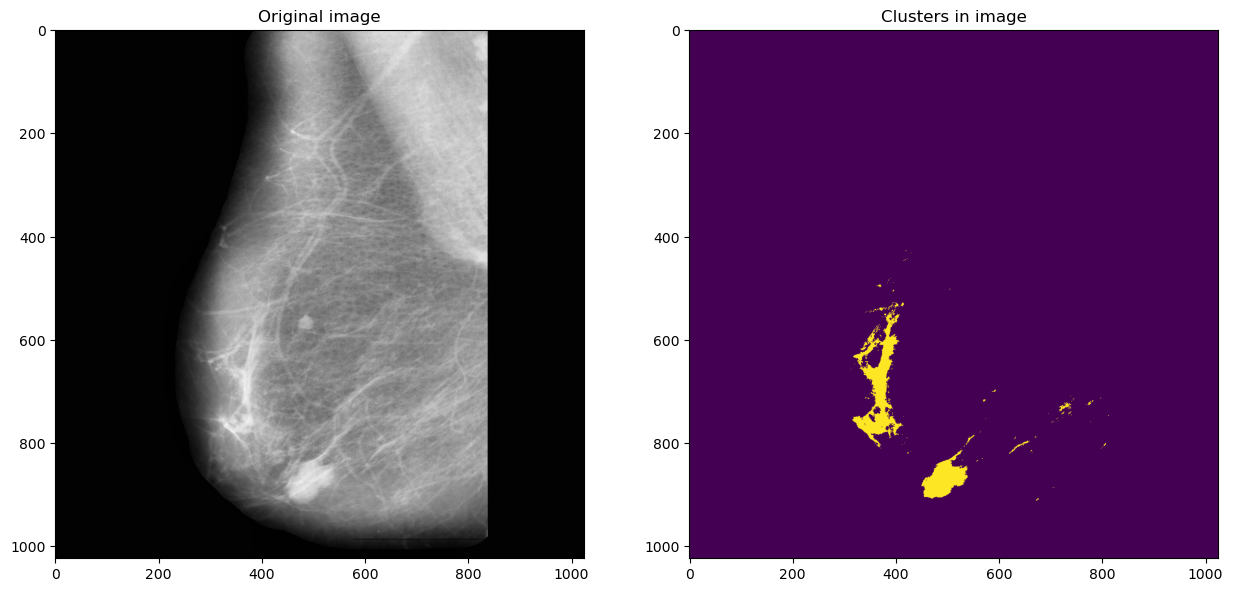

In [187]:
for i in range(5):
    image = breast_images_without_label[i]

    enhanced_image, pectoral_mask = get_pectoral_mask(image)

    # ---------------------------------- Afficher l'image des clusters --------------------------------- #
    plt.figure(figsize=(15, 10))

    plt.subplot(1,2,1)
    plt.imshow(enhanced_image, cmap="grey")  # 'jet' donne des couleurs variées aux clusters
    plt.title("Original image")

    plt.subplot(1,2,2)
    plt.imshow(pectoral_mask, cmap="viridis")  # 'jet' donne des couleurs variées aux clusters
    plt.title("Clusters in image")

    plt.show()